In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/home/boittier/Documents/phd/ff_energy")

from ff_energy.structure import Structure
from ff_energy.job import Job
from ff_energy.plot import plot_energy_MSE
import pandas as pd

# s = Structure("/home/boittier/charmm/mix3/jobs/pdbs/mix0.pdb")

atom_types = {
              # ("LIG", "O"): "OG311",
              # ("LIG", "C"): "CG331",
              # ("LIG", "H1"): "HGP1",
              # ("LIG", "H2"): "HGA3",
              # ("LIG", "H3"): "HGA3",
              # ("LIG", "H4"): "HGA3",
              # ("TIP3", "OH2"): "OT",
              # ("TIP3", "H1"): "HT",
              # ("TIP3", "H2"): "HT",
              ("LIG", "O"): "OT",
              ("LIG", "H1"): "HT",
              ("LIG", "H"): "HT",
              ("LIG", "H2"): "HT",
              }


kwargs = {"m_nproc": 4, "m_memory": 150, "m_queue": "short", 
          "m_basis": "avdz", "m_method": "run,ks,pbe0",
          "chmpath": "/home/boittier/dev-release-dcm/build/cmake/charmm",
          "modules": "module load cmake/cmake-3.23.0-gcc-11.2.0-openmpi-4.1.3",
          "c_files": ["pbe0_dz.pc"],
          "c_dcm_command": f"open unit 11 card read name pbe0_dz.pc \nDCM IUDCM 11 TSHIFT XYZ 15",
          }

JOBDIR = "clusters/pbe0dz"
# HOMEDIR = "/home/boittier/homeb"
HOMEDIR = "/home/boittier/pcbach"

In [2]:
from pathlib import Path
import os
PDBPATH = Path("/home/boittier/charmm/test/pdbs4/")
pdbs = [_ for _ in os.listdir(PDBPATH) if _.endswith("pdb")]
pdbs = pdbs[:200]

In [3]:
structures = []
for p in pdbs:
    s_path = PDBPATH / p
    s = Structure(s_path, atom_types=atom_types)
    s.set_2body()
    structures.append(s)

In [4]:
for p,s in zip(pdbs, structures):
    ID = p.split(".")[0]
    j = Job(ID, f"{HOMEDIR}/{JOBDIR}/{ID}", s, kwargs=kwargs)
    j.generate_molpro()
    # j.generate_charmm()

In [4]:
# for x in *; do cd $x; cd charmm; sbatch *.slurm; cd ../..; done
# for x in *; do cd $x/monomers; for y in *.sh; do sbatch $y; done ; cd ../..; done
# for x in *; do cd $x/cluster; for y in *.sh; do sbatch $y; done ; cd ../..; done

In [30]:
mp = HOMEDIR+"/clusters/pbe0dz/{}/monomers"

for p in pdbs:
    s_path = PDBPATH / p
    s = Structure(s_path, atom_types=atom_types)
    s.set_2body()
    ID = p.split(".")[0]
    j = Job(ID, f"{HOMEDIR}/{JOBDIR}/{ID}", s, kwargs=kwargs)
    j.generate_coloumb_interactions(monomers_path=Path(mp.format(ID)))
    j.generate_polarization(nch_per_monomer=(3, )*20,
                           monomers_path=Path(mp.format(ID))
                           )

In [ ]:
# for x in *; do cd $x/coloumb; for y in *.sh; do sbatch $y; done ; cd ../..; done
# for x in *; do cd $x/polarization; for y in *.slurm; do sbatch $y; done ; cd ../..; done

In [ ]:
# p_data = j.gather_data()

In [58]:
output = []
for p in pdbs[2:]:
    s_path = PDBPATH / p
    s = Structure(s_path, atom_types=atom_types)
    s.set_2body()
    ID = p.split(".")[0]
    j = Job(ID, f"{HOMEDIR}/{JOBDIR}/{ID}", s, kwargs=kwargs)
    o = j.gather_data()
    output.append(o)

In [7]:
o = j.gather_data()

In [8]:
o["polarization"].sum()

QMMM                                            -1520.806345
KEY        est181_17est181_10est181_15est181_20est181_13e...
NOFIELD                                         -1520.769003
pol                                                -23.43277
dtype: object

In [9]:
#  generate molpro jobs and wait
#  generate charmm jobs and wait
#  generate orbkit jobs

In [59]:
chm_df = pd.concat([_["charmm"] for _ in output])

In [60]:
chm_df

,TOTAL,ELEC,VDW,KEY
test18,22.99407,-89.90791,22.64238,test18
test105,23.47499,-53.94989,22.92519,test105
test112,23.48549,-66.54650,19.95412,test112
test459,21.62610,-36.64205,7.38603,test459
test471,22.27065,-61.37597,14.54395,test471
...,...,...,...,...
test142,22.44918,-69.88901,15.31643,test142
test405,24.76477,-66.25599,11.54044,test405
test75,28.09377,-51.96754,8.67979,test75
test412,23.17461,-73.55873,21.36494,test412


In [61]:
ctot = pd.concat([_["coloumb_total"] for _ in output])
ctot

,ECOL,KEY
test18,-175.888945,test18
test105,-132.517714,test105
test112,-132.383073,test112
test459,-77.487531,test459
test471,-127.464211,test471
test370,-171.027090,test370
test233,-122.430321,test233
test181,-135.312473,test181


In [66]:
_ = pd.concat([_["polarization"].sum() for _ in output if _["polarization"] is not None])

In [67]:
pol_df = pd.concat([_["pol_total"] for _ in output])

In [68]:
pol_df

,POL,KEY
test18,-30.392734,test18
test105,-19.980820,test105
test112,-23.962958,test112
test459,-13.112294,test459
test471,-22.074791,test471
test370,-27.885596,test370
test233,-21.589852,test233
test181,-23.432770,test181


In [15]:
#  convert molpro csv
converters = {i: lambda x: float(x.strip().replace("D","E")) * 627.503 * 10**(-3) for i in range(3,10)}
converters[0] = lambda x: x
converters[1] = lambda x: float(x.strip().replace("D","E"))
converters[2] = lambda x: float(x.strip().replace("D","E"))

#  read molpro csv
df = pd.read_csv("/home/boittier/pcbach/dimer3d/sapt.csv", converters=converters)
#  strip whitespace in column names
df = df.rename(columns=lambda x: x.strip())

In [16]:
df["KEY"] = df["KEYS"].apply(lambda x: x.strip())
df

,KEYS,RS,TS,ELST,EXCH,IND,EXIND,DISP,EXDISP,ETOT,KEY
0,1-1,0.75,180.0,-62.373121,4.056921e+02,-318.197366,2.515914e+02,-35.614933,-4.037036e-01,240.694452,1-1
1,2-1,1.00,180.0,-61.080007,1.852532e+02,-111.370336,8.627128e+01,-20.122589,3.723402e+00,82.674903,2-1
2,3-1,1.25,180.0,-36.211838,7.964523e+01,-39.555195,2.925575e+01,-11.147753,2.685490e+00,24.671678,3-1
3,4-1,1.50,180.0,-20.247849,3.307793e+01,-14.405995,9.790059e+00,-6.174418,1.462394e+00,3.502116,4-1
4,5-1,1.75,180.0,-11.790530,1.349713e+01,-5.513265,3.288282e+00,-3.447615,7.158500e-01,-3.250147,5-1
...,...,...,...,...,...,...,...,...,...,...,...
107,12-5,3.50,90.0,-0.913704,2.024254e-02,-0.046512,2.525937e-03,-0.113131,2.312804e-03,-1.048266,12-5
108,13-5,4.25,90.0,-0.473149,1.119777e-03,-0.014520,1.380030e-04,-0.038197,1.642618e-04,-0.524445,13-5
109,14-5,5.00,90.0,-0.270115,5.359255e-05,-0.005766,9.085400e-06,-0.015719,1.147403e-05,-0.291525,14-5
110,15-5,7.00,90.0,-0.081262,-5.079888e-07,-0.000868,5.742869e-07,-0.002505,1.499236e-07,-0.084635,15-5


In [17]:
# pol_3d = pd.merge(df, pol_df, on="KEY")
pol_3d = pd.merge(pol_df, ctot)
pol_3d = pd.merge(pol_3d, chm_df)
pol_3d

,POL,KEY,ECOL,TOTAL,ELEC,VDW
0,-27.025564,test306,-135.196597,20.70498,-72.67386,14.61751
1,-21.739503,test324,-124.059901,19.58474,-66.35907,13.76964
2,-30.392734,test18,-175.888945,22.99407,-89.90791,22.64238
3,-19.980820,test105,-132.517714,23.47499,-53.94989,22.92519
4,-23.962958,test112,-132.383073,23.48549,-66.54650,19.95412
5,-13.112294,test459,-77.487531,21.62610,-36.64205,7.38603
6,-22.074791,test471,-127.464211,22.27065,-61.37597,14.54395
7,-27.885596,test370,-171.027090,19.93028,-79.50871,28.39050
8,-21.589852,test233,-122.430321,22.72917,-68.96566,10.26162
9,-23.432770,test181,-135.312473,24.05006,-71.56907,18.55929


KeyError: 'TS'

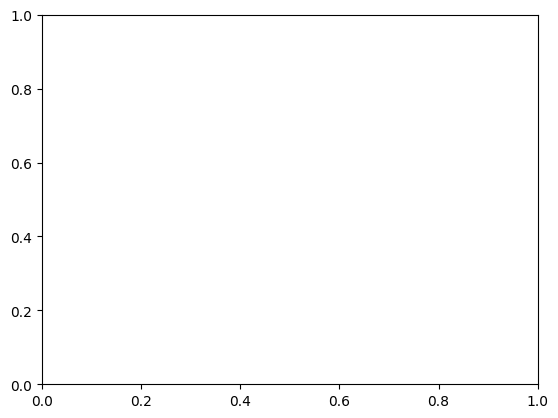

In [18]:
import matplotlib.pyplot as plt
import numpy as np

TS = list(set(df["TS"]))
TS.sort()
colors = plt.cm.plasma_r(np.linspace(0, 1, len(TS)))

ax = plt.figure().add_subplot()

    tmp = pol_3d[pol_3d["TS"] == ts]
    tmp = tmp[tmp["RS"] > 0]
    # ax.plot(tmp["RS"], tmp["ETOT"] - tmp["ELST"], "-o",  c=colors[i])
    ax.plot(tmp["RS"], tmp["POL"], "-o",  c=colors[i])
    
plt.ylim(-.1,0)
# plt.yscale("log")
plt.axhline(0, c="k", linewidth=0.1)
plt.xlim(1,8)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


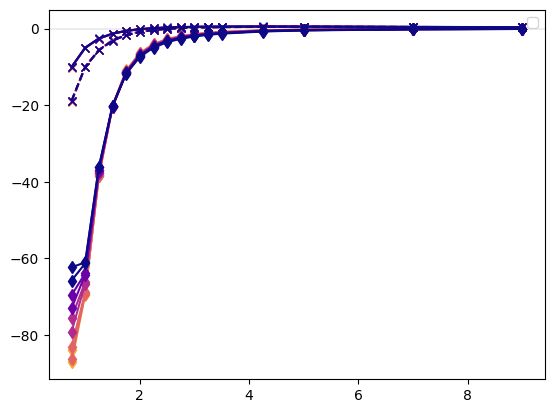

In [49]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.cm.plasma_r(np.linspace(0, 1, len(TS)))
TS = list(set(df["TS"]))
TS.sort()

ax = plt.figure().add_subplot()

for i, ts in enumerate(TS):
    tmp = pol_3d[pol_3d["TS"] == ts]
    tmp = tmp[tmp["RS"] > 0]
    # ax.plot(tmp["RS"], tmp["ETOT"] - tmp["ELST"], "-o",  c=colors[i])
    ax.plot(tmp["RS"], tmp["ECOL"], "-d",  c=colors[i])
    ax.plot(tmp["RS"], tmp["ELST"], "-d",  c=colors[i])
    ax.plot(tmp["RS"], tmp["ELEC"], "-x",  c=colors[i])
    ax.plot(tmp["RS"], tmp["ELEC"] + tmp["POL"], "--x",  c=colors[i])
    
plt.legend()
# plt.ylim(-10,0)
plt.axhline(0, c="k", linewidth=0.1)
# plt.xlim(1.5,3)

In [50]:
j.kwargs

{'m_nproc': 4,
 'm_memory': 480,
 'm_queue': 'short',
 'm_basis': 'avdz',
 'm_method': 'run,ks,pbe0',
 'chmpath': '/home/boittier/dev-release-dcm/build/cmake/charmm',
 'modules': 'module load cmake/cmake-3.23.0-gcc-11.2.0-openmpi-4.1.3',
 'c_files': ['pbe0_dz.pc'],
 'c_dcm_command': 'open unit 11 card read name pbe0_dz.pc \nDCM IUDCM 11 TSHIFT XYZ 15'}

In [19]:
pol_3d["ELECpol"] = pol_3d["ELEC"] + pol_3d["POL"]

KeyError: 'ELST'

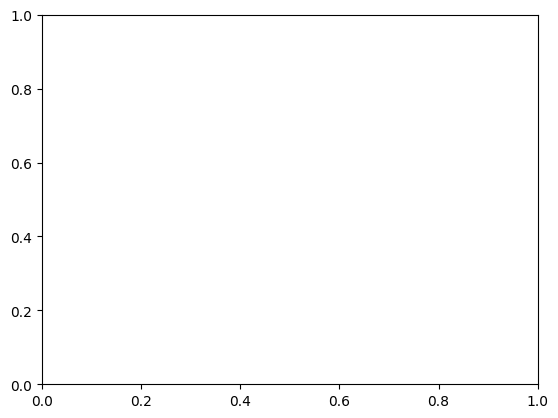

In [20]:
plot_energy_MSE(pol_3d, "ECOL", "ELST", 
                elec="ECOL", CMAP="plasma",
               xlabel="Coulomb integral [kcal/mol]",
               ylabel="SAPT-ELEC [kcal/mol]")

plt.savefig("sapt_vs_ci.pdf", bbox_inches="tight")

(-180.0, 0.0)

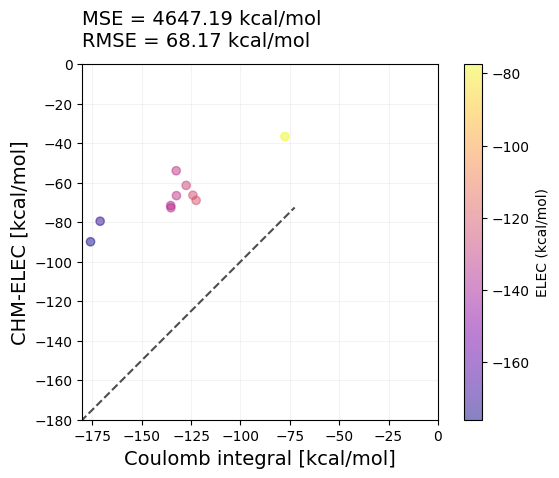

In [26]:
plot_energy_MSE(pol_3d, "ECOL", "ELEC", 
                elec="ECOL", CMAP="plasma",
               xlabel="Coulomb integral [kcal/mol]",
               ylabel="CHM-ELEC [kcal/mol]")
plt.savefig("chm_vs_ci.pdf", bbox_inches="tight")
plt.xlim(-180,0)
plt.ylim(-180,0)

(-180.0, 0.0)

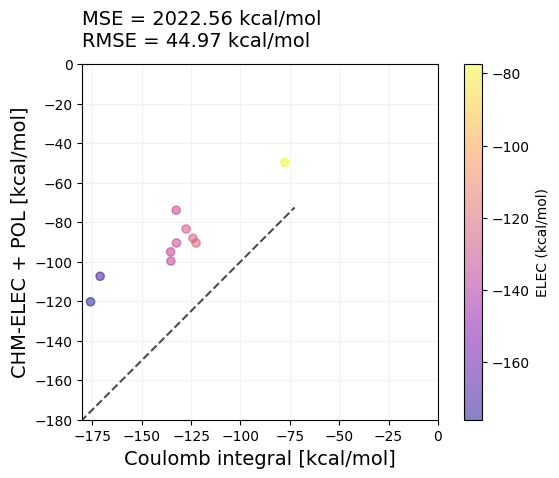

In [25]:
plot_energy_MSE(pol_3d, "ECOL", "ELECpol", 
                elec="ECOL", CMAP="plasma",
               xlabel="Coulomb integral [kcal/mol]",
               ylabel="CHM-ELEC + POL [kcal/mol]")
plt.savefig("chm_pol_vs_ci.pdf", bbox_inches="tight")
plt.xlim(-180,0)
plt.ylim(-180,0)